# Multiple Linear Regression สำหรับทำนายราคาน้ำมัน Brent

คู่ทำ MLR คือ
1. พู่กัน
2. เจฟ

## วัตถุประสงค์
ใช้ Multiple Linear Regression ในการทำนายราคาน้ำมันดิบ Brent ในวันถัดไป
โดยใช้ข้อมูลราคาย้อนหลังของน้ำมัน Brent และ WTI

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# ตั้งค่าสไตล์กราฟ
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('Libraries imported successfully!')

Libraries imported successfully!


## 2. โหลดและสำรวจข้อมูล

In [2]:
# โหลดข้อมูล
df = pd.read_csv('../data/processed/merged_oil_prices.csv')

# แปลงคอลัมน์ date เป็น datetime
df['date'] = pd.to_datetime(df['date'])

# เรียงลำดับตามวันที่
df = df.sort_values('date').reset_index(drop=True)

print(f'จำนวนข้อมูล: {len(df)} แถว')
print(f'ช่วงเวลา: {df["date"].min()} ถึง {df["date"].max()}')
print('\nคอลัมน์ในข้อมูล:')
print(df.columns.tolist())
print('\nข้อมูล 5 แถวแรก:')
df.head()

จำนวนข้อมูล: 1846 แถว
ช่วงเวลา: 2017-11-02 00:00:00 ถึง 2025-04-03 00:00:00

คอลัมน์ในข้อมูล:
['date', 'open_x', 'high_x', 'low_x', 'close_x', 'volume_x', 'average_x', 'open_y', 'high_y', 'low_y', 'close_y', 'volume_y', 'average_y']

ข้อมูล 5 แถวแรก:


,date,open_x,high_x,low_x,close_x,volume_x,average_x,open_y,high_y,low_y,close_y,volume_y,average_y
0,2017-11-02,56.73,56.73,56.73,56.73,0,56.73,51.32,51.32,51.32,51.32,0,51.32
1,2017-11-03,56.84,56.84,56.84,56.84,0,56.84,51.39,51.39,51.39,51.39,0,51.39
2,2017-11-06,57.26,57.26,57.26,57.26,0,57.26,51.07,51.07,51.07,51.07,0,51.07
3,2017-11-07,57.40,57.40,57.40,57.40,0,57.40,51.43,51.43,51.43,51.43,0,51.43
4,2017-11-08,58.17,58.17,58.17,58.17,0,58.17,52.22,52.22,52.22,52.22,0,52.22


In [3]:
# ตรวจสอบข้อมูลสถิติพื้นฐาน
print('สถิติพื้นฐานของข้อมูล:')
df.describe()

สถิติพื้นฐานของข้อมูล:


,date,open_x,high_x,low_x,close_x,volume_x,average_x,open_y,high_y,low_y,close_y,volume_y,average_y
count,1846,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000
mean,2021-07-17 19:40:14.301191680,65.546100,65.597969,65.481219,65.537378,74.929577,65.539395,60.055937,60.190195,59.891966,60.033364,890.858072,60.043776
min,2017-11-02 00:00:00,46.440000,46.440000,46.440000,46.440000,0.000000,46.440000,40.390000,40.390000,40.390000,40.390000,0.000000,40.390000
25%,2019-09-13 18:00:00,57.990000,57.990000,57.990000,57.990000,0.000000,57.990000,52.052500,52.052500,52.052500,52.052500,0.000000,52.052500
50%,2021-07-12 12:00:00,63.440000,63.440000,63.440000,63.440000,0.000000,63.440000,55.770000,55.770000,55.770000,55.770000,0.000000,55.770000
75%,2023-05-29 00:00:00,74.800000,74.975000,74.587500,74.767500,0.000000,74.796500,69.877500,70.220000,69.577500,69.877500,98.000000,69.944000
max,2025-04-03 00:00:00,83.930000,83.930000,83.930000,83.930000,11399.000000,83.930000,79.010000,79.140000,79.010000,79.010000,35933.000000,79.010000
std,NaN,9.821117,9.866789,9.767207,9.814503,572.919216,9.815091,10.131954,10.268160,9.966742,10.108302,2817.752398,10.120639


In [4]:
# ตรวจสอบค่า missing
print('จำนวนค่า missing ในแต่ละคอลัมน์:')
print(df.isnull().sum())

if df.isnull().sum().sum() == 0:
    print('\n✓ ไม่มีค่า missing ในข้อมูล')
else:
    print('\n✗ พบค่า missing ในข้อมูล')

จำนวนค่า missing ในแต่ละคอลัมน์:
date         0
open_x       0
high_x       0
low_x        0
close_x      0
volume_x     0
average_x    0
open_y       0
high_y       0
low_y        0
close_y      0
volume_y     0
average_y    0
dtype: int64

✓ ไม่มีค่า missing ในข้อมูล


## 3. Feature Engineering

สร้าง features สำหรับการทำนาย:
- Lagged features: ราคาย้อนหลัง 1, 3, 5, 7 วัน
- Moving averages: ค่าเฉลี่ย 5 และ 10 วัน
- Target: ราคา Brent วันถัดไป

In [5]:
# สร้าง DataFrame ใหม่สำหรับ features
data = df.copy()

# สร้าง lagged features สำหรับ Brent (close_x)
for lag in [1, 3, 5, 7]:
    data[f'brent_lag_{lag}'] = data['close_x'].shift(lag)

# สร้าง lagged features สำหรับ WTI (close_y)
for lag in [1, 3, 5, 7]:
    data[f'wti_lag_{lag}'] = data['close_y'].shift(lag)

# สร้าง moving averages สำหรับ Brent
data['brent_ma_5'] = data['close_x'].rolling(window=5).mean()
data['brent_ma_10'] = data['close_x'].rolling(window=10).mean()

# สร้าง moving averages สำหรับ WTI
data['wti_ma_5'] = data['close_y'].rolling(window=5).mean()
data['wti_ma_10'] = data['close_y'].rolling(window=10).mean()

# สร้าง target: ราคา Brent วันถัดไป
data['target'] = data['close_x'].shift(-1)

# ลบแถวที่มี NaN (เกิดจากการ shift และ rolling)
data_clean = data.dropna().reset_index(drop=True)

print(f'จำนวนข้อมูลหลังสร้าง features: {len(data_clean)} แถว')
print(f'จำนวน features: {len(data_clean.columns) - 2} คอลัมน์ (ไม่นับ date และ target)')
print('\nFeatures ที่สร้างขึ้น:')
feature_cols = [col for col in data_clean.columns if col not in df.columns and col != 'target']
print(feature_cols)

จำนวนข้อมูลหลังสร้าง features: 1836 แถว
จำนวน features: 24 คอลัมน์ (ไม่นับ date และ target)

Features ที่สร้างขึ้น:
['brent_lag_1', 'brent_lag_3', 'brent_lag_5', 'brent_lag_7', 'wti_lag_1', 'wti_lag_3', 'wti_lag_5', 'wti_lag_7', 'brent_ma_5', 'brent_ma_10', 'wti_ma_5', 'wti_ma_10']


## 4. เตรียมข้อมูลสำหรับ Training

In [6]:
# เลือก features ที่จะใช้ในการทำนาย
feature_columns = [
    # Brent features
    'close_x', 'open_x', 'high_x', 'low_x', 'average_x',
    'brent_lag_1', 'brent_lag_3', 'brent_lag_5', 'brent_lag_7',
    'brent_ma_5', 'brent_ma_10',
    # WTI features
    'close_y', 'open_y', 'high_y', 'low_y', 'average_y',
    'wti_lag_1', 'wti_lag_3', 'wti_lag_5', 'wti_lag_7',
    'wti_ma_5', 'wti_ma_10'
]

X = data_clean[feature_columns]
y = data_clean['target']

print(f'Shape ของ X: {X.shape}')
print(f'Shape ของ y: {y.shape}')
print(f'\nจำนวน features ทั้งหมด: {X.shape[1]}')

Shape ของ X: (1836, 22)
Shape ของ y: (1836,)

จำนวน features ทั้งหมด: 22


In [7]:
# แบ่งข้อมูลแบบ time series (ไม่ shuffle)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# เก็บวันที่สำหรับการ plot
dates_train = data_clean['date'][:train_size]
dates_val = data_clean['date'][train_size:train_size+val_size]
dates_test = data_clean['date'][train_size+val_size:]

print('การแบ่งข้อมูล:')
print(f'Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)')
print(f'Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)')
print(f'Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)')

การแบ่งข้อมูล:
Training set: 1285 samples (70.0%)
Validation set: 275 samples (15.0%)
Test set: 276 samples (15.0%)


In [8]:
# Normalize features ด้วย StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print('✓ Features normalization เสร็จสิ้น')
print(f'Mean ของ training features หลัง scaling: {X_train_scaled.mean():.6f}')
print(f'Std ของ training features หลัง scaling: {X_train_scaled.std():.6f}')

✓ Features normalization เสร็จสิ้น
Mean ของ training features หลัง scaling: -0.000000
Std ของ training features หลัง scaling: 1.000000


## 5. สร้างและ Train Multiple Linear Regression Model

ใช้ Multiple Linear Regression จาก scikit-learn:
- สมการ: $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$
- ใช้วิธี Ordinary Least Squares (OLS) ในการหาค่า coefficients
- ไม่ต้อง tune hyperparameters เพราะ Linear Regression ไม่มี hyperparameters ที่ต้องปรับ

In [9]:
# สร้าง Multiple Linear Regression model
model = LinearRegression(
    fit_intercept=True,  # คำนวณ intercept (beta_0)
    n_jobs=-1            # ใช้ทุก CPU cores
)

print('Model: Multiple Linear Regression')
print(f'Input features: {X_train_scaled.shape[1]}')
print(f'Fit intercept: {model.fit_intercept}')

Model: Multiple Linear Regression
Input features: 22
Fit intercept: True


In [10]:
# Train model
print('เริ่ม training model...')
print('=' * 50)

model.fit(X_train_scaled, y_train)

print('✓ Training เสร็จสิ้น!')
print(f'\nIntercept (β₀): {model.intercept_:.4f}')
print(f'\nCoefficients (β₁ ถึง β{len(feature_columns)}):')
for name, coef in zip(feature_columns, model.coef_):
    print(f'  {name:20s}: {coef:10.4f}')

เริ่ม training model...
✓ Training เสร็จสิ้น!

Intercept (β₀): 61.5128

Coefficients (β₁ ถึง β22):
  close_x             :     1.5280
  open_x              :     1.5280
  high_x              :     1.5280
  low_x               :     1.5280
  average_x           :     1.5280
  brent_lag_1         :     0.5057
  brent_lag_3         :    -1.9860
  brent_lag_5         :     1.9420
  brent_lag_7         :     4.4641
  brent_ma_5          :     6.5857
  brent_ma_10         :   -10.4935
  close_y             :   -18.4942
  open_y              :   -14.8585
  high_y              :    16.7619
  low_y               :    18.4497
  average_y           :    -1.3701
  wti_lag_1           :    -0.0320
  wti_lag_3           :     1.9615
  wti_lag_5           :    -0.9553
  wti_lag_7           :    -3.8484
  wti_ma_5            :    -6.4744
  wti_ma_10           :     9.0192


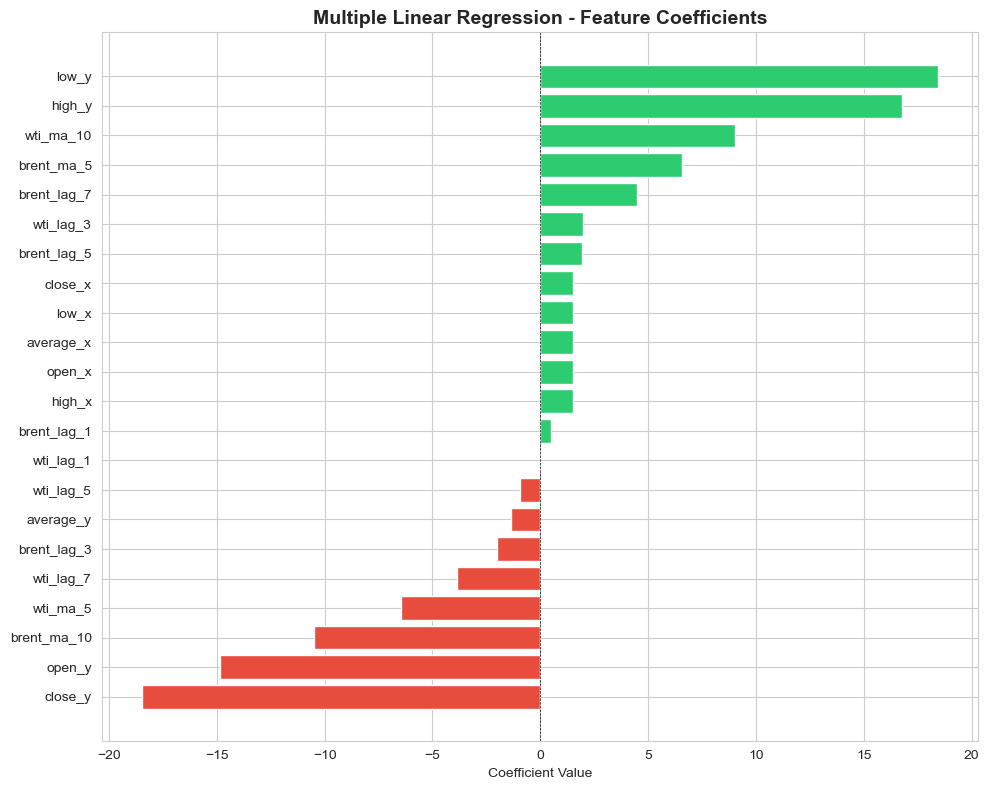


Features ที่มีอิทธิพลสูงสุด (ตามค่าสัมบูรณ์):
  close_y             :   -18.4942 (↓ ลบ)
  low_y               :    18.4497 (↑ บวก)
  high_y              :    16.7619 (↑ บวก)
  open_y              :   -14.8585 (↓ ลบ)
  brent_ma_10         :   -10.4935 (↓ ลบ)


In [11]:
# แสดง Coefficients ในรูปแบบกราฟ
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_
})
coef_df = coef_df.sort_values('Coefficient', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
ax.set_xlabel('Coefficient Value')
ax.set_title('Multiple Linear Regression - Feature Coefficients', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
plt.tight_layout()
plt.show()

print('\nFeatures ที่มีอิทธิพลสูงสุด (ตามค่าสัมบูรณ์):')
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values('Abs_Coefficient', ascending=False).head(5)
for _, row in top_features.iterrows():
    direction = '↑ บวก' if row['Coefficient'] > 0 else '↓ ลบ'
    print(f"  {row['Feature']:20s}: {row['Coefficient']:10.4f} ({direction})")

## 6. ประเมินผล Model

In [12]:
# ทำนายผล
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# คำนวณ metrics สำหรับแต่ละ set
def evaluate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f'\n📊 {set_name}:')
    print(f'   MSE  = {mse:.4f}')
    print(f'   RMSE = {rmse:.4f}')
    print(f'   MAE  = {mae:.4f}')
    print(f'   R²   = {r2:.4f}')
    print(f'   MAPE = {mape:.2f}%')
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

print('=' * 60)
print('ผลการประเมิน Multiple Linear Regression')
print('=' * 60)

train_metrics = evaluate_metrics(y_train, y_train_pred, 'Training Set')
val_metrics = evaluate_metrics(y_val, y_val_pred, 'Validation Set')
test_metrics = evaluate_metrics(y_test, y_test_pred, 'Test Set')

ผลการประเมิน Multiple Linear Regression

📊 Training Set:
   MSE  = 0.5460
   RMSE = 0.7389
   MAE  = 0.5303
   R²   = 0.9930
   MAPE = 0.85%

📊 Validation Set:
   MSE  = 1.2969
   RMSE = 1.1388
   MAE  = 0.8952
   R²   = 0.8799
   MAPE = 1.21%

📊 Test Set:
   MSE  = 1.4529
   RMSE = 1.2054
   MAE  = 0.9299
   R²   = 0.8701
   MAPE = 1.25%


In [13]:
# สรุปผลเปรียบเทียบในรูปแบบตาราง
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'Training': [train_metrics['MSE'], train_metrics['RMSE'], train_metrics['MAE'], 
                 train_metrics['R2'], train_metrics['MAPE']],
    'Validation': [val_metrics['MSE'], val_metrics['RMSE'], val_metrics['MAE'], 
                   val_metrics['R2'], val_metrics['MAPE']],
    'Test': [test_metrics['MSE'], test_metrics['RMSE'], test_metrics['MAE'], 
             test_metrics['R2'], test_metrics['MAPE']]
})

print('\n📋 สรุปผลเปรียบเทียบ:')
metrics_df


📋 สรุปผลเปรียบเทียบ:


,Metric,Training,Validation,Test
0,MSE,0.546018,1.296925,1.452916
1,RMSE,0.738930,1.138826,1.205370
2,MAE,0.530263,0.895152,0.929891
3,R²,0.993001,0.879935,0.870064
4,MAPE (%),0.850269,1.208472,1.245213


## 7. Visualization ผลลัพธ์

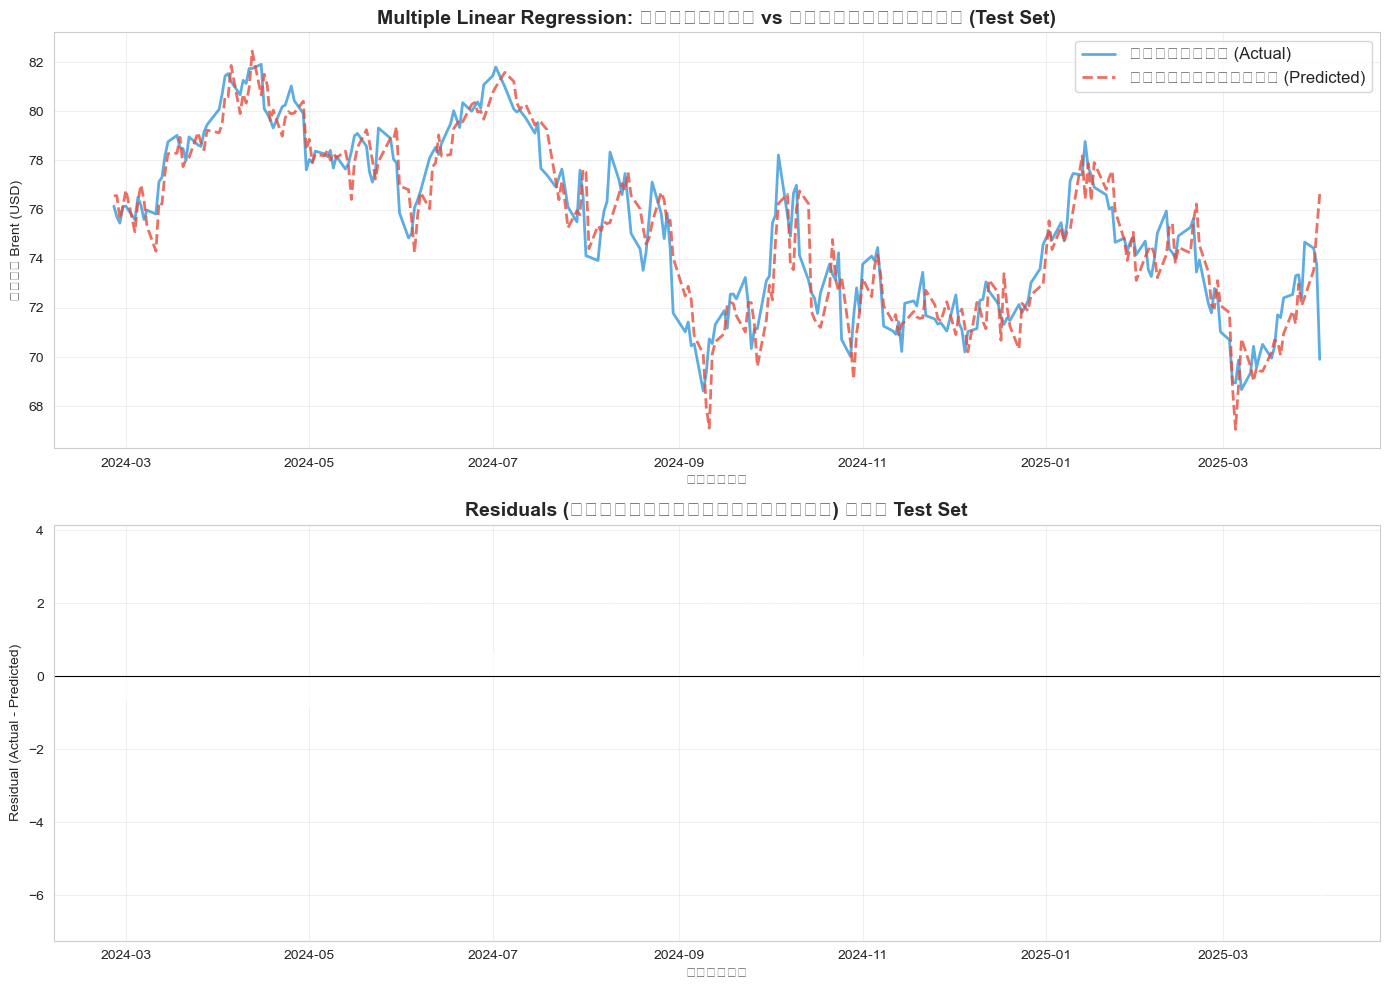

In [14]:
# กราฟเปรียบเทียบราคาจริง vs ราคาที่ทำนาย (Test Set)
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# กราฟที่ 1: ราคาจริง vs ราคาที่ทำนาย (เส้น)
axes[0].plot(dates_test.values, y_test.values, label='ราคาจริง (Actual)', 
             color='#3498db', linewidth=2, alpha=0.8)
axes[0].plot(dates_test.values, y_test_pred, label='ราคาที่ทำนาย (Predicted)', 
             color='#e74c3c', linewidth=2, alpha=0.8, linestyle='--')
axes[0].set_title('Multiple Linear Regression: ราคาจริง vs ราคาที่ทำนาย (Test Set)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('วันที่')
axes[0].set_ylabel('ราคา Brent (USD)')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# กราฟที่ 2: Residuals (ค่าความคลาดเคลื่อน)
residuals = y_test.values - y_test_pred
axes[1].bar(dates_test.values, residuals, color=['#e74c3c' if r < 0 else '#2ecc71' for r in residuals], 
            alpha=0.7, width=2)
axes[1].axhline(y=0, color='black', linewidth=0.8, linestyle='-')
axes[1].set_title('Residuals (ค่าความคลาดเคลื่อน) ของ Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('วันที่')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

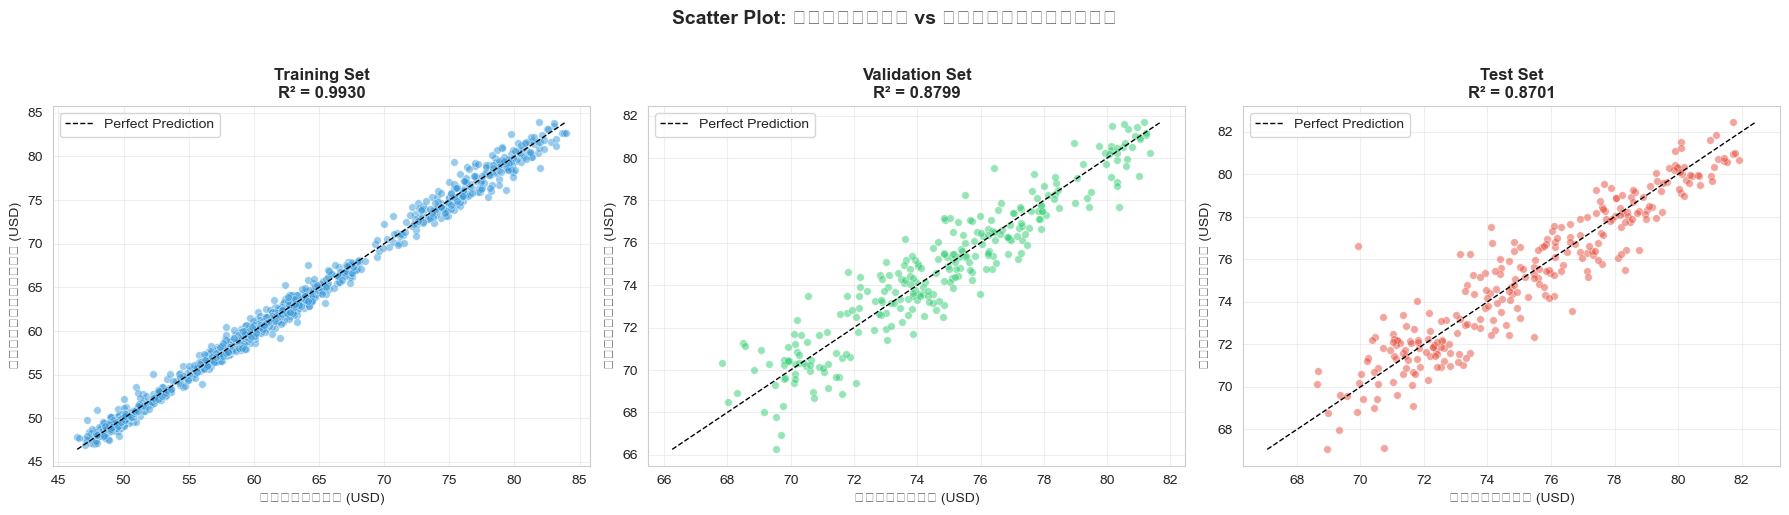

In [15]:
# กราฟ Scatter Plot: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sets = [
    (y_train, y_train_pred, 'Training Set', '#3498db'),
    (y_val, y_val_pred, 'Validation Set', '#2ecc71'),
    (y_test, y_test_pred, 'Test Set', '#e74c3c')
]

for ax, (y_true, y_pred, title, color) in zip(axes, sets):
    ax.scatter(y_true, y_pred, alpha=0.5, color=color, edgecolors='white', linewidth=0.5, s=30)
    
    # เส้น Perfect Prediction
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='Perfect Prediction')
    
    r2 = r2_score(y_true, y_pred)
    ax.set_title(f'{title}\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('ราคาจริง (USD)')
    ax.set_ylabel('ราคาที่ทำนาย (USD)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Scatter Plot: ราคาจริง vs ราคาที่ทำนาย', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

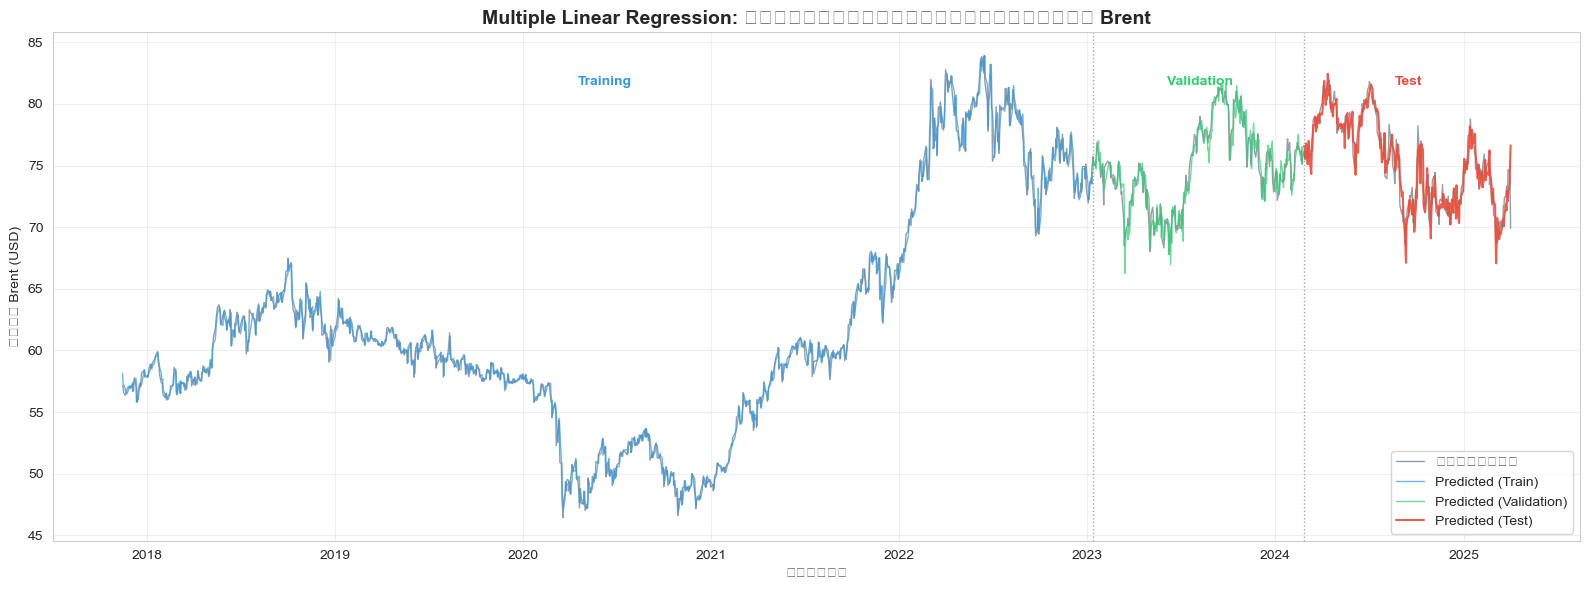

In [16]:
# กราฟภาพรวมทั้งหมด (Train + Validation + Test)
fig, ax = plt.subplots(figsize=(16, 6))

# Plot ราคาจริง
ax.plot(data_clean['date'], data_clean['target'], label='ราคาจริง', 
        color='#2c3e50', linewidth=1, alpha=0.5)

# Plot ราคาที่ทำนาย แยกตาม set
ax.plot(dates_train.values, y_train_pred, label='Predicted (Train)', 
        color='#3498db', linewidth=1, alpha=0.7)
ax.plot(dates_val.values, y_val_pred, label='Predicted (Validation)', 
        color='#2ecc71', linewidth=1, alpha=0.7)
ax.plot(dates_test.values, y_test_pred, label='Predicted (Test)', 
        color='#e74c3c', linewidth=1.5, alpha=0.9)

# แสดงเส้นแบ่ง Train/Val/Test
ax.axvline(x=dates_val.values[0], color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax.axvline(x=dates_test.values[0], color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax.text(dates_train.values[len(dates_train)//2], ax.get_ylim()[1]*0.95, 'Training', 
        ha='center', fontsize=10, color='#3498db', fontweight='bold')
ax.text(dates_val.values[len(dates_val)//2], ax.get_ylim()[1]*0.95, 'Validation', 
        ha='center', fontsize=10, color='#2ecc71', fontweight='bold')
ax.text(dates_test.values[len(dates_test)//2], ax.get_ylim()[1]*0.95, 'Test', 
        ha='center', fontsize=10, color='#e74c3c', fontweight='bold')

ax.set_title('Multiple Linear Regression: ภาพรวมการทำนายราคาน้ำมัน Brent', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('วันที่')
ax.set_ylabel('ราคา Brent (USD)')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

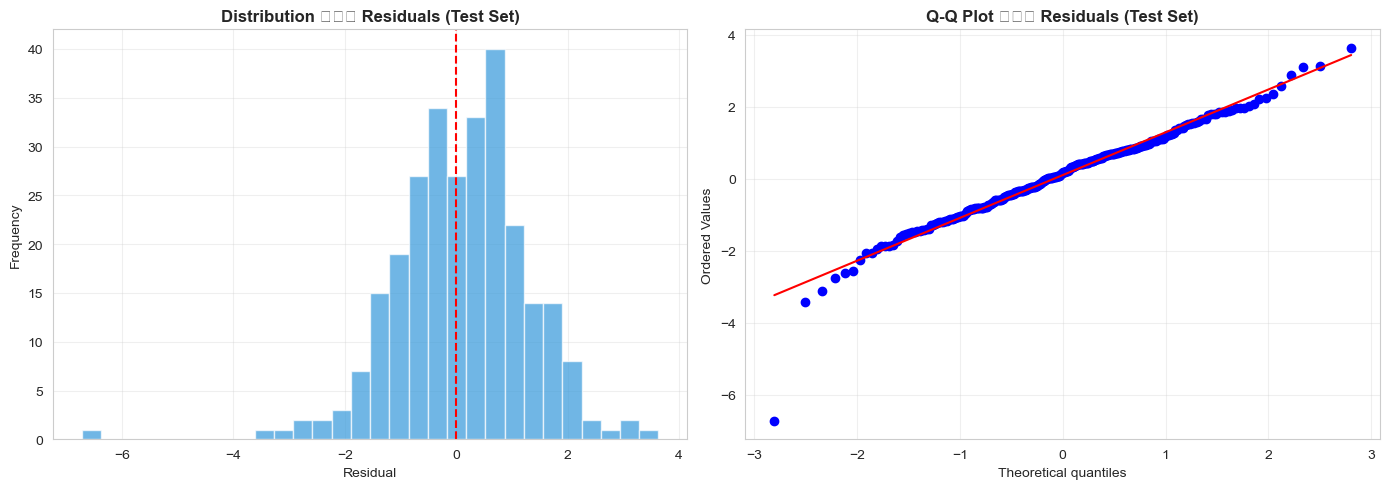

สถิติของ Residuals (Test Set):
  Mean:   0.0994
  Std:    1.2013
  Min:    -6.7240
  Max:    3.6289


In [17]:
# กราฟ Distribution ของ Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram ของ Residuals
residuals_test = y_test.values - y_test_pred
axes[0].hist(residuals_test, bins=30, color='#3498db', edgecolor='white', alpha=0.7)
axes[0].axvline(x=0, color='red', linewidth=1.5, linestyle='--')
axes[0].set_title('Distribution ของ Residuals (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
from scipy import stats
stats.probplot(residuals_test, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q Plot ของ Residuals (Test Set)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# สถิติของ Residuals
print(f'สถิติของ Residuals (Test Set):')
print(f'  Mean:   {residuals_test.mean():.4f}')
print(f'  Std:    {residuals_test.std():.4f}')
print(f'  Min:    {residuals_test.min():.4f}')
print(f'  Max:    {residuals_test.max():.4f}')

## 8. ทำนายราคาน้ำมัน Brent วันถัดไป

In [18]:
# ใช้ข้อมูลล่าสุดเพื่อทำนายราคาวันถัดไป
latest_data = data.iloc[-1:][feature_columns]
latest_data_scaled = scaler.transform(latest_data)

next_day_prediction = model.predict(latest_data_scaled)[0]
latest_date = data['date'].iloc[-1]
latest_price = data['close_x'].iloc[-1]

print('=' * 60)
print('🔮 การทำนายราคาน้ำมัน Brent วันถัดไป')
print('=' * 60)
print(f'\n📅 วันที่ล่าสุดในข้อมูล: {latest_date.strftime("%Y-%m-%d")}')
print(f'💰 ราคาปิดล่าสุด:        ${latest_price:.2f}')
print(f'\n🎯 ราคาที่ทำนายวันถัดไป: ${next_day_prediction:.2f}')

change = next_day_prediction - latest_price
change_pct = (change / latest_price) * 100

if change > 0:
    print(f'📈 เปลี่ยนแปลง: +${change:.2f} (+{change_pct:.2f}%)')
else:
    print(f'📉 เปลี่ยนแปลง: ${change:.2f} ({change_pct:.2f}%)')

🔮 การทำนายราคาน้ำมัน Brent วันถัดไป

📅 วันที่ล่าสุดในข้อมูล: 2025-04-03
💰 ราคาปิดล่าสุด:        $69.91

🎯 ราคาที่ทำนายวันถัดไป: $70.29
📈 เปลี่ยนแปลง: +$0.38 (+0.54%)


## 9. บันทึก Model

In [19]:
# บันทึก model และ scaler
import os

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# บันทึก model
model_path = os.path.join(model_dir, 'mlr_model.pkl')
joblib.dump(model, model_path)
print(f'✅ บันทึก model ที่: {model_path}')

# บันทึก scaler
scaler_path = os.path.join(model_dir, 'mlr_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f'✅ บันทึก scaler ที่: {scaler_path}')

print(f'\n📁 ไฟล์ที่บันทึก:')
print(f'  - {model_path}')
print(f'  - {scaler_path}')

✅ บันทึก model ที่: ../models\mlr_model.pkl
✅ บันทึก scaler ที่: ../models\mlr_scaler.pkl

📁 ไฟล์ที่บันทึก:
  - ../models\mlr_model.pkl
  - ../models\mlr_scaler.pkl


## 10. สรุปผล

In [20]:
print('=' * 60)
print('📊 สรุปผลการทำนายด้วย Multiple Linear Regression')
print('=' * 60)
print(f'\n📌 ข้อมูลที่ใช้:')
print(f'   - แหล่งข้อมูล: Brent & WTI historical prices')
print(f'   - จำนวนข้อมูลทั้งหมด: {len(data_clean)} แถว')
print(f'   - จำนวน features: {len(feature_columns)} ตัว')
print(f'\n📌 Features ที่ใช้:')
print(f'   - ราคาปัจจุบัน (Brent & WTI): open, high, low, close, average')
print(f'   - ราคาย้อนหลัง (Lagged): 1, 3, 5, 7 วัน')
print(f'   - ค่าเฉลี่ยเคลื่อนที่ (Moving Average): 5 และ 10 วัน')
print(f'\n📌 ผลการประเมิน (Test Set):')
print(f'   - R²:   {test_metrics["R2"]:.4f}')
print(f'   - RMSE: {test_metrics["RMSE"]:.4f}')
print(f'   - MAE:  {test_metrics["MAE"]:.4f}')
print(f'   - MAPE: {test_metrics["MAPE"]:.2f}%')
print(f'\n📌 การทำนายวันถัดไป:')
print(f'   - ราคาที่ทำนาย: ${next_day_prediction:.2f}')
print(f'\n✨ เสร็จสิ้น!')

📊 สรุปผลการทำนายด้วย Multiple Linear Regression

📌 ข้อมูลที่ใช้:
   - แหล่งข้อมูล: Brent & WTI historical prices
   - จำนวนข้อมูลทั้งหมด: 1836 แถว
   - จำนวน features: 22 ตัว

📌 Features ที่ใช้:
   - ราคาปัจจุบัน (Brent & WTI): open, high, low, close, average
   - ราคาย้อนหลัง (Lagged): 1, 3, 5, 7 วัน
   - ค่าเฉลี่ยเคลื่อนที่ (Moving Average): 5 และ 10 วัน

📌 ผลการประเมิน (Test Set):
   - R²:   0.8701
   - RMSE: 1.2054
   - MAE:  0.9299
   - MAPE: 1.25%

📌 การทำนายวันถัดไป:
   - ราคาที่ทำนาย: $70.29

✨ เสร็จสิ้น!
